<a href="https://colab.research.google.com/github/eeuuais/kaggle_comp/blob/main/(2_2)Interactive_Porto_Insights_A_Plot_ly_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Let us load in the relevant Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/kaggle_data/porto_train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
# taking a look at how many rows and columns the train dataset contains

rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


1. 데이터 품질 확인
Null 또는 누락된 값 확인

품질 검사의 일환으로 다음과 같이 기차 데이터 세트에 null 값이 있는지 빠르게 살펴보겠습니다.

In [5]:
#any() applied twice to check run the isnull check across all columns
train.isnull().any().any()

False

- 우리의 null 값 검사는 False를 반환하지만 데이터가 "-1의 값은 기능이 관찰에서 누락되었음을 나타냅니다"로 설명되어 있기 때문에 이것이 실제로 이 사례가 종료되었음을 의미하지는 않습니다. 따라서 Porto Seguro가 단순히 데이터의 모든 null 값을 -1 값으로 전면 교체했다고 생각합니다. 이제 데이터에 누락된 값이 있는지 살펴보겠습니다.
- 여기에서 값에 -1이 포함된 열을 볼 수 있으므로 예를 들어 다음과 같이 먼저 모든 -1을 null로 대체할 수 있습니다.

In [6]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

다음으로 데이터 세트에서 누락된 값을 시각화하는 데 가장 유용하고 편리한 도구인 "Missingno" 패키지의 작성자인 상주 Kaggler의 Aleksey Bilogur를 사용할 수 있으므로 확인하십시오.

<AxesSubplot:>

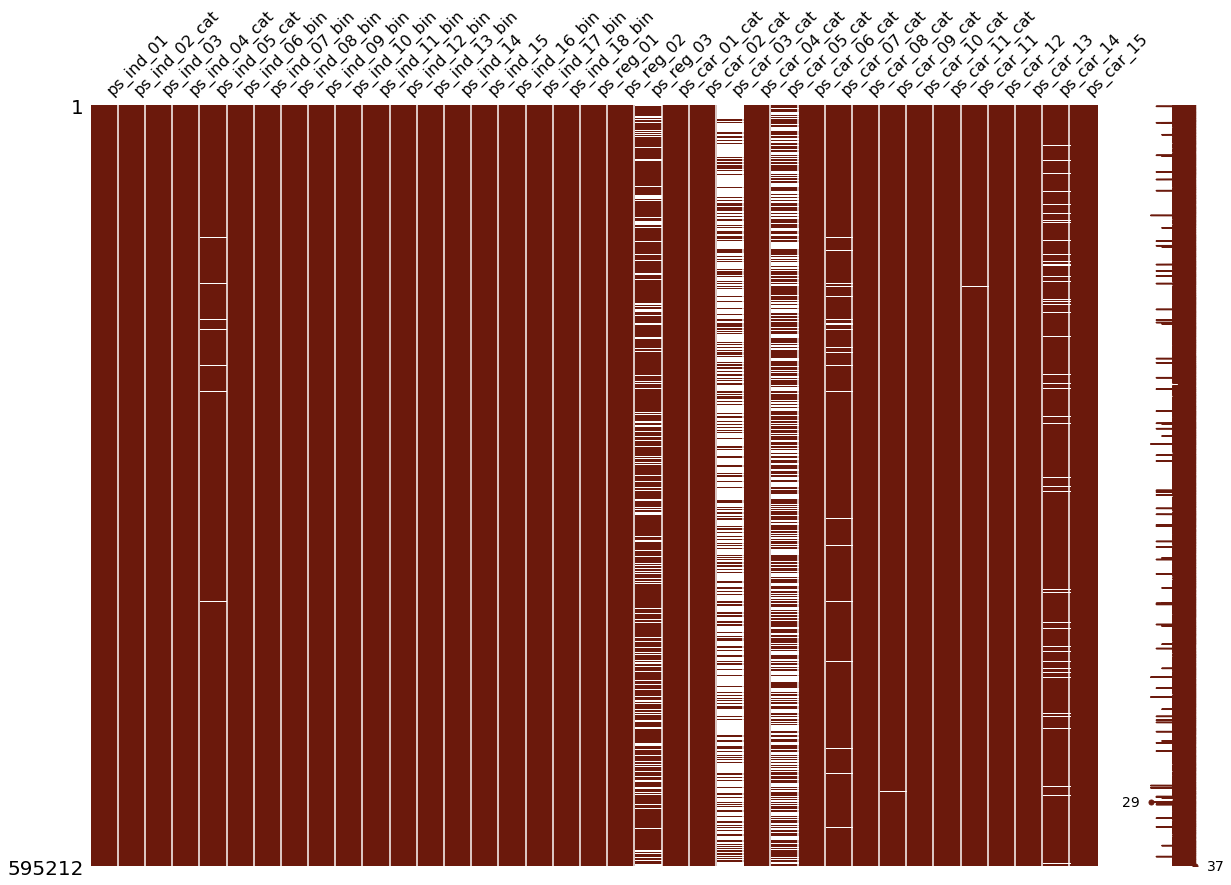

In [7]:
import missingno as msno

# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14),
            color = (0.42, 0.1, 0.05))

보시다시피 누락된 값은 이제 시각화할 때 훨씬 더 분명하고 명확해집니다. 여기서 빈 흰색 띠(누락된 데이터)는 수직의 어두운 빨간색 띠(비누락 데이터)에 중첩되어 데이터의 무효성을 반영합니다. 해당 열에서. 이 경우 총 59개의 기능 중 7개의 기능이 있음을 관찰할 수 있습니다(주석 섹션에서 Justin Nafe가 올바르게 지적한 대로 누락된 값이 있는 총 13개의 열이 있음). 실제로 null 값이 포함되었습니다. 이것은 missingno 매트릭스 플롯이 하나의 플롯에 약 40개의 홀수 기능에만 편안하게 맞을 수 있고 그 후에 일부 열이 제외될 수 있기 때문에 나머지 5개의 null 열이 제외되었기 때문입니다. 모든 null을 시각화하려면 figsize 인수를 변경하고 데이터 프레임을 분할하는 방법을 조정해 보십시오.

우리가 관찰할 수 있는 7개의 null 열에 대해 다음과 같이 여기에 나열됩니다.

ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14

누락된 값의 대부분은 _cat 접미사가 붙은 열에서 발생합니다. ps_reg_03, ps_car_03_cat 및 ps_car_05_cat 열에 대해 더 자세히 기록해야 합니다. 흰색 밴드와 어두운 밴드의 비율을 보면 이 3개 열에서 대부분의 값이 누락되었음을 알 수 있으므로 null을 -1로 대체하는 것은 좋은 전략이 아닐 수 있습니다.